# Example pipeline using sample A3 in human intestine dataset

## packages

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pickle as pkl
import os

from matplotlib import rcParams
rcParams['font.family'] = 'Arial'


import sys
sys.path.append('./scripts/')
import extract_tool_results

In [4]:
# it is only for correcting the labels while plotting
tool_name_trans_dic = {
    'cc':'CellChat',
    'cpdb':'CellPhoneDB',
    'italk':'iTALK',
    'scr':'SingleCellSignalR',
    'natmi':'NATMI',
    'icellnet':'ICELLNET',
    'nichenet':'NicheNet',
    'scmlnet':'scMLnet',
    'connectome':'Connectome',
    'cytotalk':'CytoTalk',
    'cellcall':'CellCall',
    'domino':'Domino',
    'stlearn':'stLearn',
    'cpdb_v3':'CellPhoneDB_v3',
    'giotto':'Giotto',
    'base_line':'LR product'
        }

def trans_ip_symbol(ip):
    ip = ip.split('_')
    if len(ip) > 2:
        part_b = '({})'.format('+'.join(ip[1:]))
    else:
        part_b = ip[1]
    return '{} - {}'.format(ip[0],part_b)


## Step 0: prepare directory and scripts

- for preparing the dirs and scripts for running CCI tools, you can use the script below

In [ ]:
python ./scripts/prepare_dir_script.py --sc_norm ./ST_A3_GSM4797918/data/processed/sc_norm.tsv --sc_count ./ST_A3_GSM4797918/data/processed/sc_counts.tsv --sc_meta ./ST_A3_GSM4797918/data/processed/sc_meta.tsv --deconv ./ST_A3_GSM4797918/data/STRIDE/STRIDE_spot_celltype_frac.txt --st_count ./ST_A3_GSM4797918/data/processed/st_counts.tsv --st_coord ./ST_A3_GSM4797918/data/processed/st_coord.tsv --st_meta ./ST_A3_GSM4797918/data/processed/st_meta.tsv --output_dir ./ST_A3_GSM4797918/tools


- these codes will generate the dirs for each tool like below, and you can find the example running script in the `script` dir in each tool's dir  


- tools
    - CellCall
        - output
        - script
            - submit_cellcall.sh

## Step 1: compute the d_rat and P-value for LR pairs using ST data

- codes for submit computing

In [ ]:
cd ./ST_A3_GSM4797918/data/ip_dis_sinkhorn2 && nohup python /fs/home/liuzhaoyang/project/cci_evaluation/scripts/prepare_ip_dis_sinkhorn2.py -c ../processed/st_counts.tsv -p ../processed/st_coord.tsv -o ./ &

- the results of the d_rat and P-value for LR pairs in the sample A3 can be found at `./example_data/ST_A3_GSM4797918/data/ip_dis_sinkhorn2/ip_distance_all.tsv`

- example of ip_distance_all.tsv

In [5]:
d_rat_df = pd.read_csv('./example_data/ST_A3_GSM4797918/data/ip_dis_sinkhorn2/ip_distance_all.tsv',
                      sep='\t', index_col=0)
d_rat_df.head()

,d_ori,d_shu,d_rat,p_val,pathway,ip_type
ip,,,,,,
COL1A1 - CD44,157.858325,196.208731,0.804543,0.0,COLLAGEN,ECM-Receptor
SEMA3B - (NRP1+PLXNA3),23.301063,12.901895,1.806019,0.0,SEMA3,Secreted Signaling
THBS4 - ITGA3,7.419997,4.239348,1.750269,0.0,THBS,ECM-Receptor
THBS4 - ITGB1,80.699676,56.462736,1.429256,0.0,THBS,ECM-Receptor
EFNA1 - EPHA7,81.556194,42.543582,1.917003,0.0,EPHA,Cell-Cell Contact


## Step 2: running CCI tools

- you can use your own running scripts or our example scripts to run CCI tools.
- if you follow our workflow to run the CCI tools, you can use the script below to extract results. Or you can simply load our processed result dictionary.

### extract tool results

In [ ]:
project_base_dirs = [
    './example_data/ST_A3_GSM4797918/'
]

tool_list = [
    'cc', 'cpdb', 'scr', 'natmi', 'icellnet', 'italk',
    'nichenet', 'scmlnet', 'connectome', 'cytotalk', 'cellcall',
    'domino', 'stlearn', 'cpdb_v3', 'giotto', 'base_line'
]

for project_base_dir in project_base_dirs:
    
    tool_res_dic = extract_tool_results.extract_tool_res_dic(
        project_base_dir, tool_list,
        verbose=False
    )


- Or you can simply load the tool_res_dic using codes below

In [ ]:
with open('./example_data/ST_A3_GSM4797918/evaluation_result/pkl/tool_res_dic.pkl', 'rb') as f:
    tool_res_dic = pkl.load(f)

## Step 3: calculating distance enrichment score (DES)

### Define near/far cell type pairs

#### ST celltype of sample A3

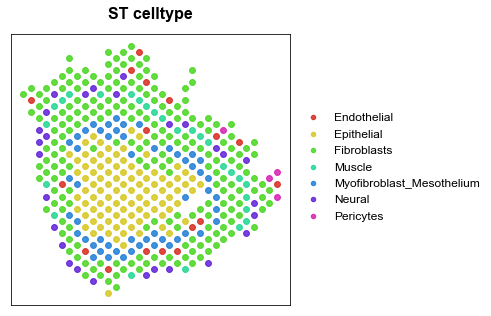

In [9]:
# using deconvolution fraction matrix and ST coordinates as input
data_base_dir = './example_data/ST_A3_GSM4797918/data'
dev_path = '{}/STRIDE/STRIDE_spot_celltype_frac.txt'.format(data_base_dir)
coord_path = '{}/processed/st_coord.tsv'.format(data_base_dir)

st_pos_df = pd.read_csv(coord_path, sep='\t', index_col=0)
dev_df = pd.read_csv(dev_path, sep='\t', index_col = 0)

max_frac_cts = dev_df.idxmax(axis=1)

st_meta_df = pd.DataFrame(max_frac_cts, index = list(dev_df.index),
                         columns=['celltype'])

extract_tool_results.plot_st_celltype(st_pos_df, st_meta_df, s=35)

In [9]:
# save the st_meta
st_meta_df.to_csv('{}/processed/st_meta_no_filtering.tsv'.format(data_base_dir),
                 sep='\t', header=None)

#### compute cell type distance type

- define near/far cell-type pair

In [4]:
project_base_dir = './example_data/ST_A3_GSM4797918/'

meta_path = '{}/data/processed/st_meta.tsv'.format(project_base_dir)
coord_path = '{}/data/processed/st_coord.tsv'.format(project_base_dir)
pkl_save_dir = '{}/data/pkl'.format(project_base_dir)

meta_df = pd.read_csv(meta_path, sep = '\t', header = None, index_col = 0)
meta_df.columns = ['celltype']

pos_df = pd.read_csv(coord_path, sep='\t', index_col=0)


##################
# cal ct distype #
##################

avg_dis_sr = extract_tool_results.cal_ct_avg_dis(meta_df, pos_df,nspot_cutoff=0)

ct_distype_sr = extract_tool_results.generate_ct_distype(avg_dis_sr)

# saving result
if not os.path.exists(pkl_save_dir):
    os.makedirs(pkl_save_dir)

with open('{}/ct_avg_dis_sr.pkl'.format(pkl_save_dir),'wb') as f:
    pkl.dump(avg_dis_sr, f)
with open('{}/ct_distype_sr.pkl'.format(pkl_save_dir),'wb') as f:
    pkl.dump(ct_distype_sr, f)

near(0): 12; far(1): 3; mid(2): 6


- `0` for the near cell type pairs, `1` for the far cell type pair

In [5]:
ct_distype_sr

Muscle|Neural                            0
Muscle|Fibroblasts                       0
Muscle|Epithelial                        2
Muscle|Endothelial                       0
Muscle|Pericytes                         2
Muscle|Myofibroblast_Mesothelium         0
Neural|Fibroblasts                       0
Neural|Epithelial                        2
Neural|Endothelial                       0
Neural|Pericytes                         1
Neural|Myofibroblast_Mesothelium         0
Fibroblasts|Epithelial                   0
Fibroblasts|Endothelial                  0
Fibroblasts|Pericytes                    2
Fibroblasts|Myofibroblast_Mesothelium    0
Epithelial|Endothelial                   2
Epithelial|Pericytes                     1
Epithelial|Myofibroblast_Mesothelium     0
Endothelial|Pericytes                    2
Endothelial|Myofibroblast_Mesothelium    0
Pericytes|Myofibroblast_Mesothelium      1
dtype: int64

### compute & plot DES

cc
cpdb
scr
natmi
icellnet
italk
nichenet
scmlnet
connectome
cytotalk
cellcall
domino
stlearn
cpdb_v3
giotto
base_line


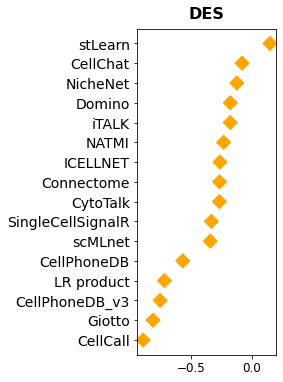

In [21]:
project_base_dirs = [
    './example_data/ST_A3_GSM4797918/'
]

tool_list = [
    'cc', 'cpdb', 'scr', 'natmi', 'icellnet', 'italk',
    'nichenet', 'scmlnet', 'connectome', 'cytotalk', 'cellcall',
    'domino', 'stlearn', 'cpdb_v3', 'giotto', 'base_line'
]

for project_base_dir in project_base_dirs:
    
    #######################
    # extract tool result #
    #######################
    # you can skip this step, if you have ran the codes above and had the tool_res_dic
    
    # tool_res_dic = extract_tool_results.extract_tool_res_dic(
    #     project_base_dir, tool_list,
    #     verbose=False
    # )
    
    
    ###################################################
    # loading d_rat, tool_res_dic, celltype pair type #
    ###################################################
    d_rat_df = pd.read_csv('{}/data/ip_dis_sinkhorn2/ip_distance_all.tsv'.format(project_base_dir),
                          sep='\t', index_col = 0)

    with open('{}/evaluation_result/pkl/tool_res_dic.pkl'.format(project_base_dir), 'rb') as f:
        tool_res_dic = pkl.load(f)
    with open('{}/data/pkl/ct_distype_sr.pkl'.format(project_base_dir), 'rb') as f:
        ct_distype_sr = pkl.load(f)
    
    
    ############################
    # computing & plotting DES #
    ############################
    extract_tool_results.plot_es_workflow(
        d_rat_df,
        tool_res_dic,
        ct_distype_sr,
        tool_name_trans_dic,
        '{}/evaluation_result/figure'.format(project_base_dir),
        '{}/evaluation_result/pkl'.format(project_base_dir), 
        fig_save_flag=True, pkl_save_flag=True, save_tail_name='',
        verbose=False,
        color_diff=True,
    )    


## using all the two samples in the human intestine dataset

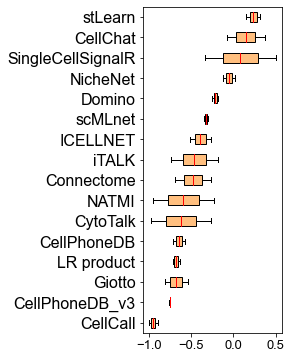

In [8]:
res_dic_files = [
    './example_data/ST_A3_GSM4797918/evaluation_result/pkl/tool_ES_dic_sinkhorn2.pkl',
    './evaluation_result/Human_intestine/ST_A4_GSM4797919/tool_ES_dic_sinkhorn2.pkl'
]

out_dir = './evaluation_result'

tool_list = [
    'cc', 'cpdb', 'scr', 'natmi', 'icellnet', 'italk',
    'nichenet', 'scmlnet', 'connectome', 'cytotalk', 'cellcall',
    'domino', 'stlearn', 'cpdb_v3', 'giotto', 'base_line'
]

res_dic_list = []
for tmp_f in res_dic_files:
    with open(tmp_f,'rb') as f:
        tmp_dic = pkl.load(f)
    
    # keep the tool number is the same between different samples
    del_tools = [tool for tool in tmp_dic if tool not in tool_list]
    for tool in del_tools:
        del tmp_dic[tool]
    res_dic_list.append(tmp_dic)

# plotting DES boxplot for all samples
extract_tool_results.plot_ES_multi_scatter(
    res_dic_list, tool_name_trans_dic, 
    '{}/figure'.format(out_dir),
    fontsize=16, fontsize_x=13, title_flag=False,
    verbose=True, color_diff=True, fig_save_flag=False, figtail='_ls' 
)
